# 环境配置
`raster-vision`提供了构建好的docker镜像，前期学习过程中推荐使用Docker镜像。

1. 采用`raster-vision`提供的镜像，这个镜像比较多大，6G左右，拉取的时间会比较长    
```bash
docker pull quay.io/azavea/raster-vision:pytorch-latest
```

2. 自己构建镜像
```bash
git clone https://github.com/azavea/raster-vision.git
cd raster-vision
docker/build -n raster-vision
```
3. 启动镜像，docker也支持gpu，带上参数`--runtime=nvidia`就行
```bash
docker run -itd --rm quay.io/azavea/raster-vision:pytorch-latest /bin/bash
```

4. vscode中连接docker，然后装上jupyter插件，就可以在jupyter中写代码了

# 读取矢量数据
`raster-vision`基于`GDAL/OGR`对矢量、影像进行处理，所以`GDAL/OGR`支持的数据格式，理论上`raster-vision`也支持，并且`raster-vision`还扩展了对`S3`的支持。
1. [GDAL支持的遥感影像列表](https://gdal.org/en/stable/drivers/raster/index.html)
2. [GDAL支持的矢量格式列表](https://gdal.org/en/stable/drivers/vector/index.html)

`VectorSource`是`raster-vision`的遥感矢量IO的一个核心类，它提供了读取、写入、栅格化等操作。`GeoJsonVectorSource`

`raster-vision`是以影像为基础的，所以`VectorSource`的输入需要一个坐标转换关系, 可以将`VectorSource`转到影像匹配到坐标系上，从而为两者建立关系。

In [1]:
%env AWS_NO_SIGN_REQUEST=YES
%env NO_ALBUMENTATIONS_UPDATE=1

env: AWS_NO_SIGN_REQUEST=YES
env: NO_ALBUMENTATIONS_UPDATE=1


In [2]:
from rastervision.core.data import GeoJSONVectorSource, RasterioCRSTransformer

crs_transformer = RasterioCRSTransformer.from_uri(
    "data/RGB-PanSharpen_AOI_2_Vegas_img205.tif",
    map_crs= 'epsg:4326'
)

label_uri = "data/buildings_AOI_2_Vegas_img205.geojson"
vector_source = GeoJSONVectorSource(label_uri, crs_transformer)

GeoJSONVectorSource提供了三种获取Geom的方式:
1. GeoJSON的dict对象 (`VectorSource.get_geojson()`)
2. Shapely的geoms对象 (`VectorSource.get_geoms()`)
3. GeoPandas的GeoDataFram对象 (`VectorSource.get_dataframe()`)

1. 第一种，转为dict对象

In [3]:
geojson = vector_source.get_geojson()
geojson["features"][:1]


[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': (((552.0, 588.0),
     (485.0, 588.0),
     (485.0, 604.0),
     (483.0, 604.0),
     (483.0, 621.0),
     (503.0, 621.0),
     (503.0, 625.0),
     (515.0, 625.0),
     (515.0, 634.0),
     (552.0, 634.0),
     (552.0, 588.0)),)},
  'properties': {'OBJECTID': 0,
   'FID_VEGAS_': 0,
   'Id': 0,
   'FID_Vegas': 0,
   'Name': 'None',
   'AREA': 0.0,
   'Shape_Leng': 0.0,
   'Shape_Le_1': 0.0,
   'SISL': 0.0,
   'OBJECTID_1': 0,
   'Shape_Le_2': 0.0,
   'Shape_Le_3': 0.000625,
   'Shape_Area': 0.0,
   'partialBuilding': 0.0,
   'partialDec': 1.0}}]

2. 接下来我们转为`shapely.Geometry`对象，并用`matplotlib`画出来

In [4]:
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from shapely.geometry.base import BaseGeometry
import numpy as np  

def plot_geoms(geoms: list[BaseGeometry]):
    fig, ax = plt.subplots(figsize=(5, 5))
    for g in geoms:
        if g.geom_type == "Polygon":
            xy = np.array(g.exterior.coords)
            patch = patches.Polygon(xy, color="#55cc77", alpha=0.5)
            ax.add_patch(patch)
            patch = patches.Polygon(xy, edgecolor="#005511", fill=None, alpha=1)
            ax.add_patch(patch)
    ax.autoscale()


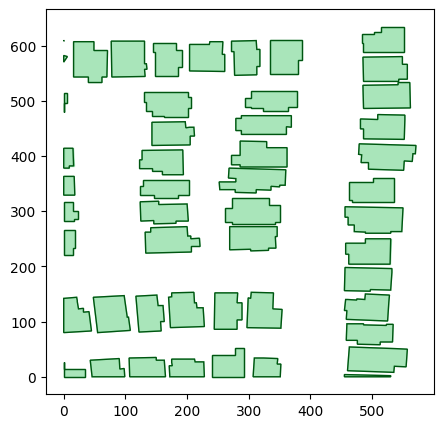

In [5]:
geoms = vector_source.get_geoms()
plot_geoms(geoms)


3. 接下来我们转为`geopandas.DataFrame`对象

In [6]:
df = vector_source.get_dataframe()
df.head()

,geometry,OBJECTID,FID_VEGAS_,Id,FID_Vegas,Name,AREA,Shape_Leng,Shape_Le_1,SISL,OBJECTID_1,Shape_Le_2,Shape_Le_3,Shape_Area,partialBuilding,partialDec
0,"POLYGON ((552 588, 485 588, 485 604, 483 604, ...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000625,0.0,0.0,1.0
1,"POLYGON ((561 533, 562 487, 486 486, 485 528, ...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000658,0.0,0.0,1.0
2,"POLYGON ((553 466, 552 430, 486 431, 486 449, ...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000627,0.0,0.0,1.0
3,"POLYGON ((551 374, 494 376, 494 388, 482 388, ...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000744,0.0,0.0,1.0
4,"POLYGON ((536 316, 468 316, 468 321, 464 321, ...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000634,0.0,0.0,1.0


<Axes: >

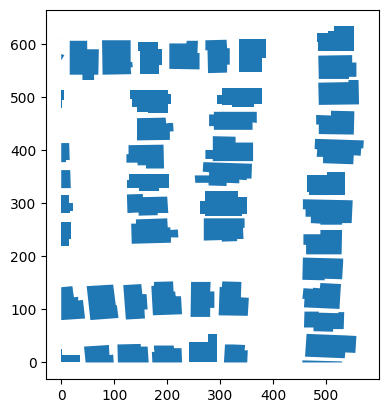

In [7]:
df.plot()

# 矢量数据处理

在遥感解译里，原始矢量数据最常用的用途就是作为真值，经过预处理形成Label，配合遥感影像进行训练。在`raster-vision`里同样提供了一系列的`VectorTransformers`来进行矢量数据的处理

1. 在提供标签的时候，一般要附带语义信息，比如这个图斑的建筑类型或者用地类型等，在`raster-vision`里通过`id`来区分，所以`raster-vision`提供了`ClassInferenceTransformer`来帮我们进行`id`的过滤或者复制等。
    1. 给数据集中的所有图斑一个相同的`id`（常用）
    2. 通过一个映射对象(dict)赋予对应的`id`
    3. 通过MapBox-style(参考 https://docs.mapbox.com/mapbox-gl-js/style-spec/other/#other-filter)规则赋予对应的`id`

看下如何给数据集中的图斑一个相同的`id`

In [ ]:
from rastervision.core.data import GeoJSONVectorSource, RasterioCRSTransformer, ClassInferenceTransformer

crs_transformer = RasterioCRSTransformer.from_uri(
    "data/RGB-PanSharpen_AOI_2_Vegas_img205.tif",
    map_crs= 'epsg:4326'
)

label_uri = "data/buildings_AOI_2_Vegas_img205.geojson"
vector_source = GeoJSONVectorSource(label_uri, crs_transformer,
                                    vector_transformers=[ClassInferenceTransformer(default_class_id=1)])

/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
df = vector_source.get_dataframe()
df[['geometry', 'class_id']].head()

,geometry,class_id
0,"POLYGON ((552 588, 485 588, 485 604, 483 604, ...",1
1,"POLYGON ((561 533, 562 487, 486 486, 485 528, ...",1
2,"POLYGON ((553 466, 552 430, 486 431, 486 449, ...",1
3,"POLYGON ((551 374, 494 376, 494 388, 482 388, ...",1
4,"POLYGON ((536 316, 468 316, 468 321, 464 321, ...",1


2. 对于点、线格式的矢量数据，为了能够和遥感影像匹配，通常我们会做一点点的缓冲，然后栅格化

<Axes: >

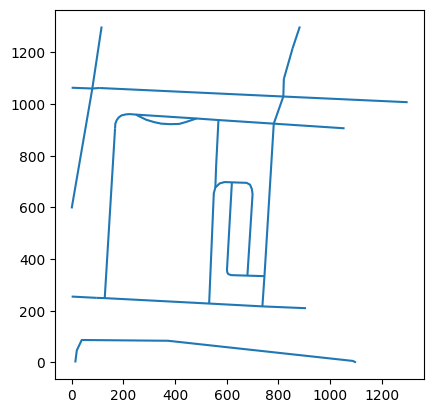

In [6]:
from rastervision.core.data import GeoJSONVectorSource, RasterioCRSTransformer

crs_transformer = RasterioCRSTransformer.from_uri(
    "data/SN3_roads_train_AOI_4_Shanghai_PS-RGB_img999.tif",
    map_crs= 'epsg:4326'
)

label_uri = "data/SN3_roads_train_AOI_4_Shanghai_geojson_roads_img999.geojson"
vector_source = GeoJSONVectorSource(label_uri, crs_transformer)

vector_source.get_dataframe().plot()

<Axes: >

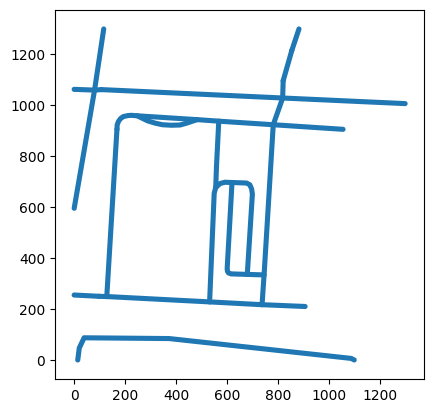

In [5]:
from rastervision.core.data import GeoJSONVectorSource, RasterioCRSTransformer, BufferTransformer

crs_transformer = RasterioCRSTransformer.from_uri(
    "data/SN3_roads_train_AOI_4_Shanghai_PS-RGB_img999.tif",
    map_crs= 'epsg:4326'
)

label_uri = "data/SN3_roads_train_AOI_4_Shanghai_geojson_roads_img999.geojson"
vector_source = GeoJSONVectorSource(label_uri, crs_transformer,
                                    vector_transformers=[BufferTransformer(geom_type='LineString', default_buf=10)])
vector_source.get_dataframe().plot()

3. 当矢量数据处理好后，我们就需要栅格化，然后作为标签进行训练。

In [ ]:
from rastervision.core.data import GeoJSONVectorSource, RasterioCRSTransformer, RasterizedSource, ClassInferenceTransformer

crs_transformer = RasterioCRSTransformer.from_uri(
    "data/RGB-PanSharpen_AOI_2_Vegas_img205.tif",
    map_crs= 'epsg:4326'
)

label_uri = "data/buildings_AOI_2_Vegas_img205.geojson"
vector_source = GeoJSONVectorSource(
    label_uri, 
    crs_transformer, 
    vector_transformers=[ClassInferenceTransformer(default_class_id=1)]
    )

rasterized_source = RasterizedSource(
    vector_source,
    # 对应到NoData的class_id
    background_class_id=0, 
    # bbox一般是要传影像的范围，但是目前我们只有矢量数据，所以这里传矢量数据的范围
    bbox=vector_source.bbox)

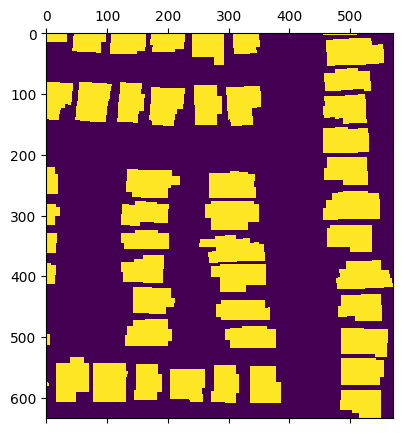

In [10]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(rasterized_source[:,:])
plt.show()

In [4]:
%pip install -q folium 

Note: you may need to restart the kernel to use updated packages.


# 矢量数据可视化
`folium`是基于`leaflet`实现的地图可视化库，可以方便的GIS数据展示在Leaflet地图中，并方便的和Jupyter集成。
1. `m = folium.Map(location=(23.5236, 113.6750))`
2. `folium.GeoJson(geojson_data, name="hello world").add_to(m)`
3. `folium.Marker().add_to(m)`

In [28]:
import folium
m = folium.Map(location=(36.1957153499, -115.30127385))
m

In [31]:
from rastervision.core.data import GeoJSONVectorSource, RasterioCRSTransformer

crs_transformer = RasterioCRSTransformer.from_uri(
    "data/RGB-PanSharpen_AOI_2_Vegas_img205.tif",
    map_crs= 'epsg:4326'
)

label_uri = "data/buildings_AOI_2_Vegas_img205.geojson"
vector_source = GeoJSONVectorSource(
    label_uri, 
    crs_transformer)

geojson = vector_source.get_geojson(to_map_coords=True)
folium.GeoJson(geojson).add_to(m)
m